In [1]:
import pandas as pd
import numpy as np
import seaborn
import time
from prefixSpan import prefix_span
from gsp import gsp
from data_loader import importDatabase
import matplotlib.pyplot as plt
import random
import subprocess

In [2]:
#database paths
bible = "dataSets/BIBLE.txt"
#leviathan = "dataSets/LEVIATHAN.txt"
#korsak = "dataSets/kosarak10k.txt"

In [22]:
# speed vs supp theshold %
test_support_thresholds = np.linspace(0.05, 0.5, 5)
database_paths = [bible]
databases = [random.sample(importDatabase(path), 1000) for path in database_paths]
#databases = [importDatabase(path) for path in database_paths]
names = ["Bible"]

execution_times = []
supp_thresholds = []
algorithm = []
database_name = []

for sth in test_support_thresholds:
    for db, db_name in zip(databases, names):
        # calculate actual support value
        sup = int(sth*len(db))

        print(f"Database: {db_name}, Supp%: {sth}, supp value: {sup}")

        # time datamining 
        start_time = time.time()
        with open('prefix_span_result.txt', 'w') as file:
            prefix_span(sup, db, file)
        end_time = time.time()
        elapsed_time = end_time - start_time

        # collect data
        execution_times.append(elapsed_time)
        supp_thresholds.append(sth)
        algorithm.append("prefix_span")
        database_name.append(db_name)

        # time datamining 
        start_time = time.time()
        with open('gsp_result.txt', 'w') as file:
            gsp(sup, db, file)
        end_time = time.time()
        elapsed_time = end_time - start_time

        # collect data
        execution_times.append(elapsed_time)
        supp_thresholds.append(sth)
        algorithm.append("GSP")
        database_name.append(db_name)

        # time datamining 
        start_time = time.time()
        #command = f"java -jar spmf.jar run PrefixSpan dataSets/BIBLE.txt output.txt {sth}%"
        #process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        process.communicate()
        end_time = time.time()
        elapsed_time = end_time - start_time

        # collect data
        execution_times.append(elapsed_time)
        supp_thresholds.append(sth)
        algorithm.append("SPMF PrefixSpan")
        database_name.append(db_name)

time_vs_sup = pd.DataFrame({"execution time [s]": execution_times, 
                            "support threshold [%]": supp_thresholds, 
                            "algorithm": algorithm,
                            "database": database_name})


Database: Bible, Supp%: 0.1, supp value: 100
Database: Bible, Supp%: 0.2, supp value: 200
Database: Bible, Supp%: 0.30000000000000004, supp value: 300
Database: Bible, Supp%: 0.4, supp value: 400
Database: Bible, Supp%: 0.5, supp value: 500


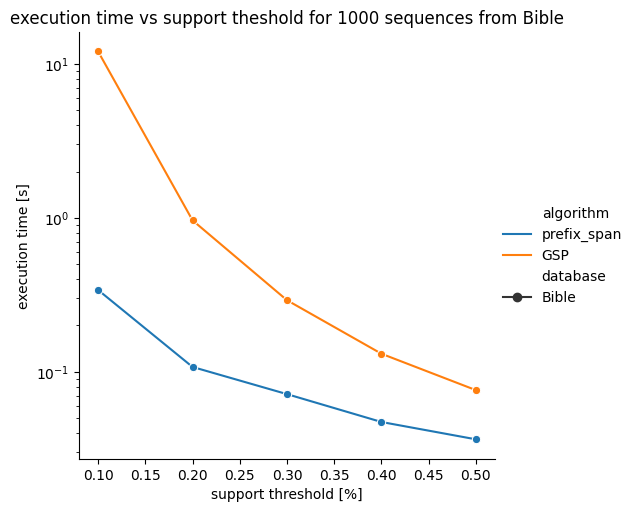

In [24]:
# plot results 
seaborn.relplot(data=time_vs_sup[time_vs_sup["algorithm"] != "SPMF PrefixSpan"], #data=time_vs_sup,
                 x="support threshold [%]",
                 y="execution time [s]", 
                 hue="algorithm",
                 style="database",
                 kind="line",
                 markers=True
                )
plt.title("execution time vs support theshold for 1000 sequences from Bible")
plt.yscale('log')


In [5]:
# speed vs n of sequences
database_paths = [bible]
databases = [importDatabase(path) for path in database_paths]
names = ["Bible"]
size_test_support_threshold = int(4000)

maxSize = min([len(db) for db in databases])
db_sizes = np.linspace(100, 20000, 5)

execution_times = []
database_size = []
algorithm = []
supp_thresholds = []
database_name = []


for db, db_name in zip(databases, names):
    for size in db_sizes:
        print(f"Database: {db_name}, db size: {size}")

        # sample from database to create smalled database
        db_sampled = random.sample(db, int(size))

        # time datamining 
        start_time = time.time()
        with open('prefix_span_result.txt', 'w') as file:
            prefix_span(size_test_support_threshold, db_sampled, file)
        end_time = time.time()
        elapsed_time = end_time - start_time

        # collect data
        execution_times.append(elapsed_time)
        supp_thresholds.append(size_test_support_threshold)
        algorithm.append("prefix_span")
        database_name.append(db_name)
        database_size.append(int(size))

        # time datamining 
        start_time = time.time()
        with open('gsp_result.txt', 'w') as file:
            gsp(size_test_support_threshold, db_sampled, file)
        end_time = time.time()
        elapsed_time = end_time - start_time

        # collect data
        execution_times.append(elapsed_time)
        supp_thresholds.append(size_test_support_threshold)
        algorithm.append("GSP")
        database_name.append(db_name)
        database_size.append(int(size))


time_vs_size = pd.DataFrame({"execution time [s]": execution_times, 
                            "support threshold [%]": supp_thresholds, 
                            "algorithm": algorithm,
                            "database": database_name,
                            "N of sequences": database_size})


Database: Bible, db size: 100.0
Database: Bible, db size: 5075.0
Database: Bible, db size: 10050.0
Database: Bible, db size: 15025.0
Database: Bible, db size: 20000.0


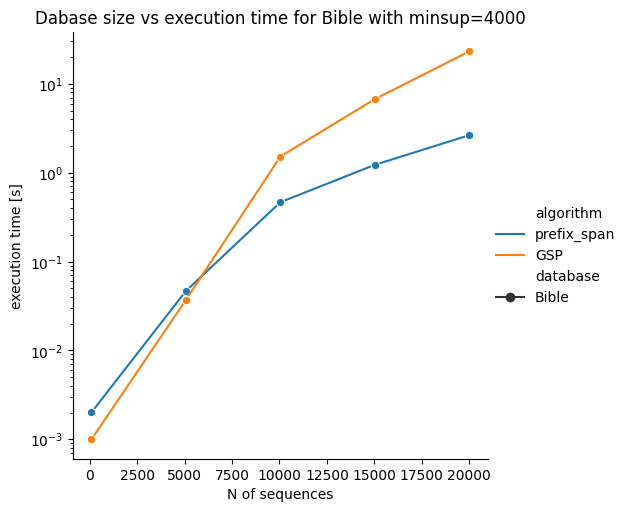

In [11]:
# plot results 
seaborn.relplot(data=time_vs_size, 
                 x="N of sequences",
                 y="execution time [s]", 
                 hue="algorithm",
                 style="database",
                 #col="database",
                 kind="line",
                 markers=True
                )
plt.title("Dabase size vs execution time for Bible with minsup=4000")
plt.yscale('log')